# SVM

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
class SVM:
    """
    class SVM: SVM分类器
    |   SVM(kernel : str=None, C : float=None)
    |
    |  Parameters
    |  ----------
    |  kernel : str, optional
    |      SVM分类器所使用的核函数
    |      默认值None，表示不使用核函数，此时模型为线性SVM
    |  C : float, optional
    |      SVM使用的软间隔参数
    |      默认值为np.inf，表示所处理的问题线性可分，模型退化为硬间隔分类器
    |
    |  Attributes
    |  ----------
    |  fit(self, X : np.ndarray, y : np.ndarray, epsilon : float=1e-3, EPOCHS : int=100) -> None
    |      SVM训练函数，给定输入特征X和标签y，KKT容许误差epsilon和最大迭代次数
    |  predict(self, X : np.ndarray) -> np.ndarray
    |      预测函数，给定输入特征X，输出模型预测的分类标签
    |  accuracy(self, X : np.ndarray, y_true : np.ndarray) -> float
    |      正确率评估函数，给定输入特征X及对应的真实标签y_true，计算模型在输入X上的正确率
    |
    """
    def __init__(self, kernel : str=None, C : float=np.inf):
        """
        __init__(self, kernel : str=None, C : float=None)
            类初始化构造函数
        Parameters
        ----------
        kernel : str, optional
           SVM分类器所使用的核函数
           默认值None，表示不使用核函数，此时模型为线性SVM
        C : float, optional
           SVM使用的软间隔参数
           默认值为np.inf，表示所处理的问题线性可分，模型退化为硬间隔分类器
        """
        self.__ker = kernel # 核函数
        self._C = C # 软边界
        self._alpha = None # Lagrange乘子，shape = (N,)
        self._w = None # 朝平面系数
        self._beta = 0 # 超平面的偏置项
        self._E = None # 预测误差，shape = (N,)
        self.N = None # 样本量
        self._X = None # 特征
        self._y = None # 标签
        self.__epsilon = None # KKT条件容许误差
    
    def fit(self, X : np.ndarray, y : np.ndarray, epsilon : float=1e-3, EPOCHS : int=100) -> None:
        """
        fit(self, X : np.ndarray, y : np.ndarray, epsilon : float=1e-3, EPOCHS : int=100) -> None
            SVM训练函数，给定输入特征X和标签y，KKT容许误差epsilon和最大迭代次数\n
            使用SMO算法求解对偶问题
        Parameters
        ----------
        X : np.ndarray
            输入特征
        y : np.ndarray
            数据的标签
        epsilon : float, optional
            检验KKT条件的容许误差\n
            默认值1e-3，当所有样本的KKT条件满足该容许误差时，算法收敛
        EPOCHS : int, optional
            模型的最大迭代次数\n
            默认值为100，应该设置一个足够大的迭代次数保证算法收敛
        """
        self.N = len(y) # 计算样本量
        # 添加对样本的访问
        self._X = X
        self._y = y
        # 初始化相关变量
        self._alpha = np.zeros(self.N) # 初始化Lagrange乘子
        # 初始化精度
        self.__epsilon = epsilon
        # 初始化预测误差
        self._E = self._beta - y
        epoch = 0
        # SMO算法求解
        while epoch < EPOCHS:
            # 第一层循环，找训练样本中赵违反KKT条件最严重的点
            first,SV_index,other_index = self.__choose_alpha1(exclude=[])
            # 如果没有找到违反KKT条件的点，说明已经收敛
            if first == None:
                print("所有样本KKT条件满足，算法收敛")
                break
            # 第二层循环，找到更新变化量最大的样本
            second, alpha2_new = self.__choose_alpha2(first,SV_index,other_index,exclude=[])
            # 进行更新alpha1, alpha2
            alpha1_old = self._alpha[first]
            alpha2_old = self._alpha[second]
            alpha1_new = alpha1_old + self._y[first]*self._y[second]*(alpha2_old - alpha2_new)
            self._alpha[first] = max(alpha1_new,0)
            self._alpha[second] = max(alpha2_new,0)
            # 更新偏置项beta
            beta1_new = -self._E[first] - self._y[first]*self.__inner_product(self._X[first],self._X[first])*(alpha1_new - alpha1_old)\
                        -self._y[second]*self.__inner_product(self._X[second],self._X[first])*(alpha2_new - alpha2_old) + self._beta
            beta2_new = -self._E[second] - self._y[first]*self.__inner_product(self._X[first],self._X[second])*(alpha1_new - alpha1_old)\
                        -self._y[second]*self.__inner_product(self._X[second],self._X[second])*(alpha2_new - alpha2_old) + self._beta
            if (0 < alpha1_new < self._C) and (0 < alpha2_new < self._C):
                self._beta = beta1_new
            else:
                self._beta = (beta1_new + beta2_new)/2
            # 更新预测误差
            self._E[first] = self.__updateE(first)
            self._E[second] = self.__updateE(second)
            epoch = epoch + 1
        # 求解超平面
        self._w = self.__getW()
    
    # 预测函数
    def predict(self, X : np.ndarray) -> np.ndarray:
        """
        predict(self, X : np.ndarray) -> np.ndarray
            预测函数，给定输入特征X，输出模型预测的分类标签
        Parameters
        ----------
        X : np.ndarray
            输入特征
        
        Return
        ----------
        y_pred : np.ndarray
            模型在输入特征X上的预测
        """
        y_pred = []
        for i in range(X.shape[0]):
            y_pred.append(np.sign(self.__pred_func(X[i])))
        return np.array(y_pred)
    
    # 准确率函数
    def accuracy(self, X : np.ndarray, y_true : np.ndarray) -> float:
        """
        accuracy(self, X : np.ndarray, y_true : np.ndarray) -> float
            正确率评估函数，给定输入特征X及真实标签y_pred，计算模型在数据集X上的正确率
        Parameters
        ----------
        X : np.ndarray
            输入特征
        y_pred : np.ndarray
            数据X对应的真实标签
        
        Return
        ----------
        acc : float
            模型在输入特征X上的正确率
        """
        y_pred = self.predict(X)
        acc = (y_pred == y_true).sum() / len(y_pred)
        return acc
    
    # 挑选第一个alpha
    def __choose_alpha1(self, exclude : list=[]) -> int:
        """
        __choose_alpha1(self, exclude : list=[]) -> int
            SMO算法中的外层循环，用于选择第一个更新变量\n
            第一个更新变量是违反KKT条件最严重的变量
        Parameters
        ----------
        exclude : list, optional
            要过滤的索引列表，则算法不会在exclude中出现的点选取更新点\n
            默认值为[]，表示不做筛选
        
        Return
        ----------
        (first,SV_index,other_index) : tuple
            返回一个元组，第一个元素代表外层循环确定的更新变量\n
            第二个元素代表处在分界线上的支持向量的索引，第三个元素表示其它数据样本索引
        """
        # 第一层循环，找训练样本中赵违反KKT条件最严重的点
        worst = 0
        first = None
        # 先找(0,C)的样本点，即在支持向量边界上寻找
        SV = (self._alpha > 0) & (self._alpha < self._C)
        SV_index = list(np.where(SV)[0])
        SV_index = list(set(SV_index) - set(exclude))
        other_index = list(np.where(~SV)[0])
        other_index = list(set(other_index) - set(exclude))
        for i in SV_index:
            err = self.__eachKKT(self._X[i],self._y[i],self._alpha[i])
            if err > self.__epsilon and err > worst:
                worst = err
                first = i
        if first != None:
            return first,SV_index,other_index
        # 在(0,C)内没找到，在其他样本上寻找
        for i in other_index:
            err = self.__eachKKT(self._X[i],self._y[i],self._alpha[i])
            if err > self.__epsilon and err > worst:
                worst = err
                first = i
        return first,SV_index,other_index
    
    # 挑选第二个alpha
    def __choose_alpha2(self, first : int, SV_index : list, other_index : list,\
                        exclude : list=[], delta : float=1e-5) -> tuple:
        """
        __choose_alpha2(self, first : int, SV_index : list, other_index : list, exclude : list=[], delta : float=1e-5) -> tuple
            SMO算法中的内层循环，用于选择第二个更新变量\n
            第二个更新变量是基于第一个变量，使得模型更新幅度最大的变量
        Parameters
        ----------
        first : int
            在外层循环中筛选出的第一个变量\n
            通过函数self.__choose_alpha1得到
        SV_index : list
            处在分界线上的支持向量的索引，通过函数self.__choose_alpha1返回
        other_index : list
            其它数据样本索引，通过函数self.__choose_alpha1返回
        exclude : list, optional
            要过滤的索引列表，则算法不会在exclude中出现的点选取更新点\n
            默认值为[]，表示不做筛选
        delta : float, optional
            检验更新量阈值，当第二个变量的更新幅度小于delta时，重新选择变量\n
            默认值1e-5

        Return
        ----------
        (second,alpha2_new) : tuple
            返回一个元组，第一个元素代表内层循环确定的更新变量\n
            第二个元素代表第二个变量的更新值
        """
        # 寻找预测误差变化最大的点
        if self._E[first] >= 0:
            # 先把first从列表中移除
            temp = self._E[first]
            self._E[first] = np.inf
            second = np.argmin(self._E)
            # 恢复first
            self._E[first] = temp
        else:
            # 先把first从列表中移除
            temp = self._E[first]
            self._E[first] = -np.inf
            second = np.argmax(self._E)
            # 恢复first
            self._E[first] = temp
        # 基于找到的second，计算alpha2的更新值
        alpha2_new = self.__alpha2_update(first,second)
        # 如果更新条件未满足
        if abs(alpha2_new - self._alpha[second]) < delta:
            # 先从支持向量边界上选
            for second in SV_index:
                alpha2_new = self.__alpha2_update(first,second)
                if abs(alpha2_new - self._alpha[second]) > delta:
                    return second,alpha2_new
            # 没有找到，则在所有样本上选
            for second in other_index:
                alpha2_new = self.__alpha2_update(first,second)
                if abs(alpha2_new - self._alpha[second]) > delta:
                    return second,alpha2_new
            # 如果还是没找到，则重新挑选alpha1，再次遍历寻找
            exclude.append(first) # 注意将现在使用的第一个变量添加到排除列表
            first, SV_index, other_index = self.__choose_alpha1(exclude=exclude)
            return self.__choose_alpha2(first,SV_index,other_index,exclude,delta)
        # 如果条件满足，直接返回
        else:
            return second,alpha2_new

    # 计算更新后的alpha2的值
    def __alpha2_update(self, first : int, second : int) -> float:
        """
        __alpha2_update(self, first : int, second : int) -> float
            SMO算法中更新第二个变量的算法
        Parameters
        ----------
        first : int
            在外层循环中筛选出的第一个变量\n
            通过函数self.__choose_alpha1得到
        second : int
            在内层循环中筛选出的第一个变量\n
            通过函数self.__choose_alpha2得到

        Return
        ----------
        alpha2 : float
            第二个变量的更新值
        """
        # 计算eta
        eta = self.__inner_product(self._X[first],self._X[first])\
                + self.__inner_product(self._X[second],self._X[second])\
                - 2*self.__inner_product(self._X[first],self._X[second])
        # 用更新前的数据计算左右边界
        if self._y[first]*self._y[second] < 0:
            L = max(0,self._alpha[second]-self._alpha[first])
            H = min(self._C,self._C + self._alpha[second] - self._alpha[first])
        else:
            L = max(0,self._alpha[second]+self._alpha[first]-self._C)
            H = min(self._C,self._alpha[second]+self._alpha[first])
        if self._E[first] == self._E[second]:
            alpha2_new = self._alpha[second]
        else:
            alpha2_new = self._alpha[second] + self._y[second]*(self._E[first]-self._E[second])/eta
        # 进行裁剪
        alpha2 = self.__clip(alpha2_new,L,H)
        return alpha2
    
    # 更新预测误差
    def __updateE(self, index : int) -> float:
        """
        __updateE(self, index : int) -> float
            SMO算法中更新预测误差E的算法
        Parameters
        ----------
        index : int
            需要更新的预测误差的下标

        Return
        ----------
        newE : float
            更新后的预测误差
        """
        SV_index = np.where(self._alpha > 0)[0]
        return sum(self._y[SV_index]*self._alpha[SV_index]*self.__inner_product(self._X[index],self._X[SV_index]))\
                + self._beta - self._y[index]

    # 根据核函数计算内积
    def __inner_product(self, x1 : np.ndarray, X : np.ndarray) -> float:
        """
        __inner_product(self, x1 : np.ndarray, X : np.ndarray) -> float
            基于给定的核函数，计算内积
        Parameters
        ----------
        x1 : np.ndarray
            某个数据样本点，它必须是一维的
        X : np.ndarray
            需要参与内积运算的数据集，可以是一维的，也可以是多维的\n
            如果是一维的，则将计算内积<x1,X>\n
            如果是多维的，则将让x1与X的每一行Xi做内积<x1,Xi>，最后得到一个内积向量

        Return
        ----------
        inner_product : float or np.ndarray
            x1与X的内积
        """
        if not self.__ker:
            return np.inner(x1,X)
    
    # 预测函数
    def __pred_func(self, x0 : np.ndarray) -> float:
        """
        __pred_func(self, x0 : np.ndarray) -> float
            给定某个实例x0，计算函数间隔g(x0) = <w,x0> + b
        Parameters
        ----------
        x0 : np.ndarray
            某个数据样本点，它必须是一维的

        Return
        ----------
        <w,x0> + b : float
            x0到超平面的函数间隔
        """
        return np.sum(self._alpha*self._y*self.__inner_product(x0,self._X)) + self._beta
    
    # 裁剪
    def __clip(self, alpha2 : float, L : float, H : float) -> float:
        """
        __clip(self, alpha2 : float, L : float, H : float) -> float
            裁剪函数，基于SMO算法中第二算法的更新值，将其裁剪至区间[0,C]内，以满足软间隔条件
        Parameters
        ----------
        alpha2 : float
            待裁剪的第二个变量更新值
        L : float
            基于更新前的左边界
        H : float
            基于更新前的有边界

        Return
        ----------
        alphaw_new : float
            裁剪后的第二个变量更新值
        """
        if alpha2 > H:
            return H
        elif alpha2 >= L:
            return alpha2
        else:
            return L
    
    # 每一个实例的KKT条件判断
    def __eachKKT(self, x0 : np.ndarray, y0 : int, alpha : float) -> float:
        """
        __eachKKT(self, x0 : np.ndarray, y0 : int, alpha : float) -> float
            计算每一个实例的KKT误差，该误差将用于选择SMO算法的外层变量\n
            或用于判断算法是否收敛
        Parameters
        ----------
        x0 : np.ndarray
            待检验的数据实例
        y0 : int
            该实例对应的标签
        alpha : float
            该实例对应的Lagrange乘子

        Return
        ----------
        err : float
            该实例对应的KKT误差，该误差将用于选择SMO算法的外层变量\n
            或用于判断算法是否收敛
        """
        subject = y0*self.__pred_func(x0)
        if alpha <= 0:
            return 1 - subject
        elif alpha < self._C:
            return abs(subject - 1)
        else:
            return subject - 1
    
    # 计算坐标系数
    def __getW(self) -> np.ndarray:
        """
        __getW(self) -> np.ndarray -> np.ndarray
            计算模型的分离超平面系数

        Return
        ----------
        w : np.ndarray
            模型求解得到的分离超平面系数
        """
        return np.sum(self._alpha.reshape(-1,1)*self._y.reshape(-1,1)*self._X,axis=0)

### 绘制支持向量

In [3]:
def plot_surport_vector(model):
    SV_index = np.where(model._alpha > 0)[0]
    plt.scatter(model._X[SV_index,0],model._X[SV_index,1],c='none',edgecolors='black',s=150,label='Support Vector')
    margin_index_pos = np.where((model._alpha > 0) & (model._alpha < model._C) & (model._y == 1))[0][0]
    margin_index_neg = np.where((model._alpha > 0) & (model._alpha < model._C) & (model._y == -1))[0][0]
    w = model._w
    b = model._beta
    hyperplane_x = np.linspace(-1,1,100)
    hyperplane_y = -(b + w[0]*hyperplane_x)/w[1]
    hyperplane_y = hyperplane_y.flatten()
    plt.plot(hyperplane_x,hyperplane_y,c='green',ls='-.',label='Hyperplane')
    pos_x = model._X[margin_index_pos]
    neg_x = model._X[margin_index_neg]
    pos_y = pos_x[1] + w[0]/w[1]*pos_x[0] - w[0]/w[1]*hyperplane_x
    pos_y = pos_y.flatten()
    neg_y = neg_x[1] + w[0]/w[1]*neg_x[0] - w[0]/w[1]*hyperplane_x
    neg_y = neg_y.flatten()
    plt.plot(hyperplane_x,pos_y,c='black',ls='--',label='Interface')
    plt.plot(hyperplane_x,neg_y,c='black',ls='--',label='Interface')

## 测试

In [4]:
N = 50
sigma = 0.2
x1 = np.random.randn(N,2)*sigma + np.array([0.5,0.5])
y1 = np.ones(shape=(N,))
x2 = np.random.randn(N,2)*sigma + np.array([-0.5,-0.5])
y2 = -np.ones(shape=(N,))

In [5]:
X_train = np.concatenate((x1,x2))
y_train = np.concatenate((y1,y2))

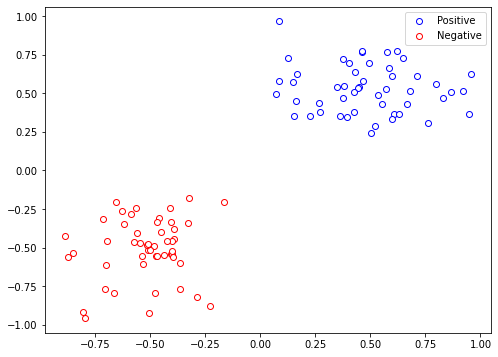

In [6]:
fig = plt.figure(figsize=(8,6))
plt.scatter(x1[:,0],x1[:,1],c='w',edgecolors='b',label='Positive')
plt.scatter(x2[:,0],x2[:,1],c='w',edgecolors='r',label='Negative')
plt.legend()

In [7]:
model = SVM(C=np.inf)
model.fit(X_train,y_train,epsilon=0.01,EPOCHS=500)

所有样本KKT条件满足，算法收敛


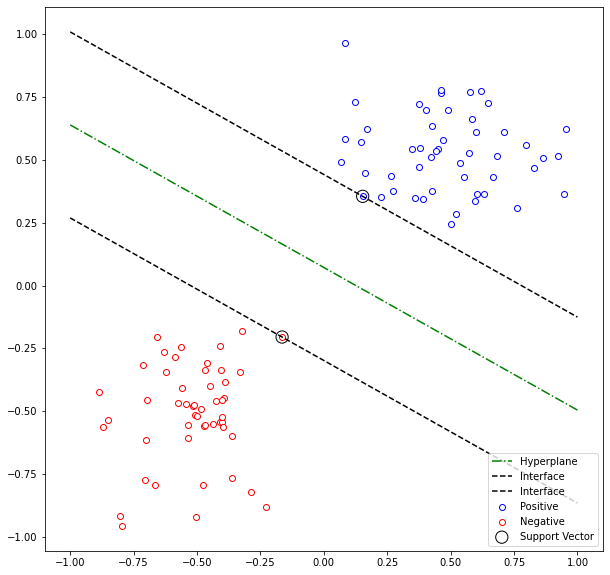

In [8]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x1[:,0],x1[:,1],c='w',edgecolors='b',label='Positive')
plt.scatter(x2[:,0],x2[:,1],c='w',edgecolors='r',label='Negative')
plot_surport_vector(model)
plt.legend(loc='lower right')

----